In [37]:
from torchtext.data import to_map_style_dataset
from torch.utils.data import Dataset
from torchtext import datasets
import seaborn as sns
from torch import nn
import numpy as np
import torchtext
import string
import torch

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [39]:
class LSTMTextClassificationModel(nn.Module):
    def __init__(self, vocabulary, embed_dim, hidden_dim, num_class, pad_idx):
        super(LSTMTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(len(vocabulary), embed_dim, padding_idx=pad_idx)
        glove = torchtext.vocab.GloVe(name="6B", dim=embed_dim)
        self.embedding.weight.data.copy_(self.create_matrix(glove, embed_dim, vocabulary))
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)


    def create_matrix(self, glove, embed_dim, vocabulary):
        embedding_matrix = torch.zeros((len(vocabulary), embed_dim))
        for word, idx in vocabulary.get().items():
            embedding_matrix[idx] = glove[word]
        embedding_matrix[vocabulary["<PAD>"]] = torch.zeros(embed_dim)
        embedding_matrix[vocabulary["<UNK>"]] = torch.randn(embed_dim)
        return embedding_matrix


    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

In [40]:
class NewsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx][0]
        label = int(self.data[idx][1]) - 1
        return text, label

In [41]:
train_iter, test_iter = datasets.AG_NEWS(split=('train', 'test'))
train_ds = to_map_style_dataset(train_iter)
test_ds = to_map_style_dataset(test_iter)
train = np.array(train_ds)
test = np.array(test_ds)
dictionary = torchtext.vocab.GloVe(name="6B", dim=50).stoi

def process_phrase(phrase):
    result = []
    for word in phrase:
        if word not in dictionary.keys():
            result.append("<UNK>")
            continue
        result.append(word)
    return result + ["<PAD>"] * (50 - len(result))

def remove_punctuation(sentence):
    result = ""
    for char in sentence:
        if char not in string.punctuation + "\n": result += char
    return result

def preprocess_sentences(data):
    result = []
    for tup in data:
        phrase = remove_punctuation(tup[1])
        splitted_phrase = phrase.lower().split(" ")
        if len(tup[1].lower().split(" ")) > 50: continue
        result.append([process_phrase(splitted_phrase), int(tup[0])])
    return result

preprocessed_data_for_test = preprocess_sentences(test)
preprocessed_data_for_training = preprocess_sentences(train)
distinct_words = set(word for tup in preprocessed_data_for_training + preprocessed_data_for_test for word in tup[0])
vocab = {word: dictionary[word] if word in dictionary.keys() else i+1 for i, word in enumerate(distinct_words)}
vocab["<PAD>"] = 400000
vocab["<UNK>"] = 400001

class Vocabulary:
    def __init__(self, dictionary):
        self._dictionary = dictionary

    def __len__(self):
        return len(self._dictionary.keys())

    def __getitem__(self, item):
        return self._dictionary[item]

    def get(self):
        return self._dictionary

vocabulary = Vocabulary({**vocab, **dictionary})

def codify_sentence(sentence):
    return torch.tensor(np.array([vocabulary[word] for word in sentence]))

def codify_corpus(corpus):
    return [[codify_sentence(tup[0]), tup[1]] for tup in corpus]


test_data = codify_corpus(preprocessed_data_for_test)
test_loader = torch.utils.data.DataLoader(NewsDataset(test_data), batch_size=64, shuffle=True)

In [42]:
def fill_matrix(matrix, output, labels):
    for index in range(output.shape[0]):
        matrix[output[index]][labels[index]] += 1


def get_confusion_matrix(model, data_loader):
    matrix = np.zeros((4, 4))
    for batch, (phrases, labels) in enumerate(data_loader):
        phrases, labels = phrases.to(device), labels.to(device)
        fill_matrix(matrix, model(phrases).argmax(1), labels)
    return matrix


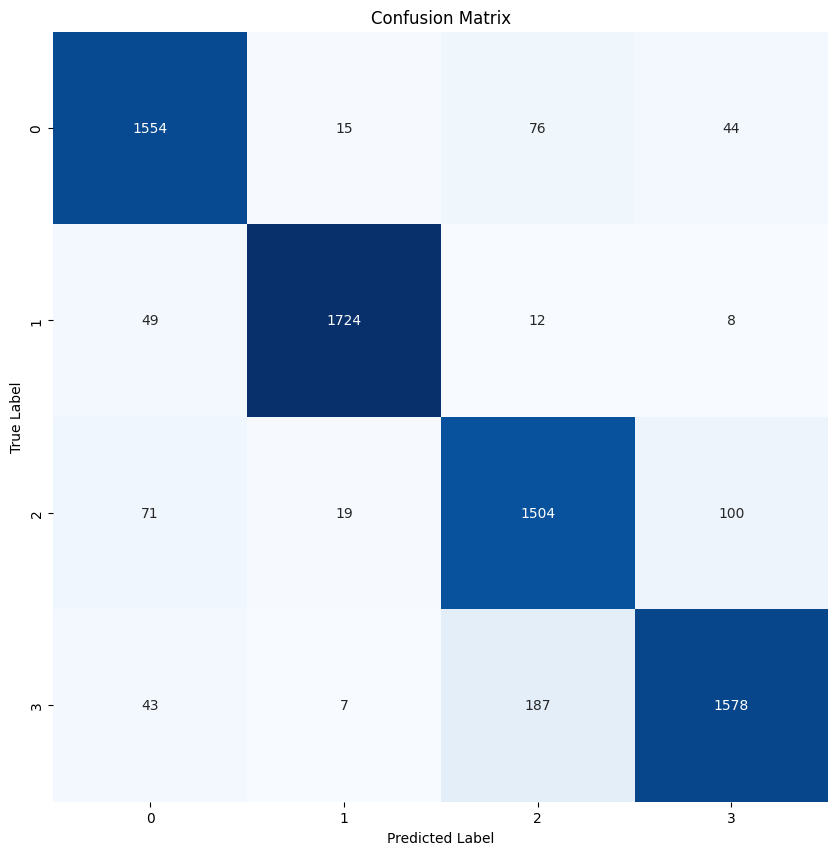

In [43]:
from matplotlib import pyplot as plt

model = torch.load("models/model50.pt")
model.to(device)
matrix = get_confusion_matrix(model, test_loader)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt="g", cmap="Blues", cbar=False)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

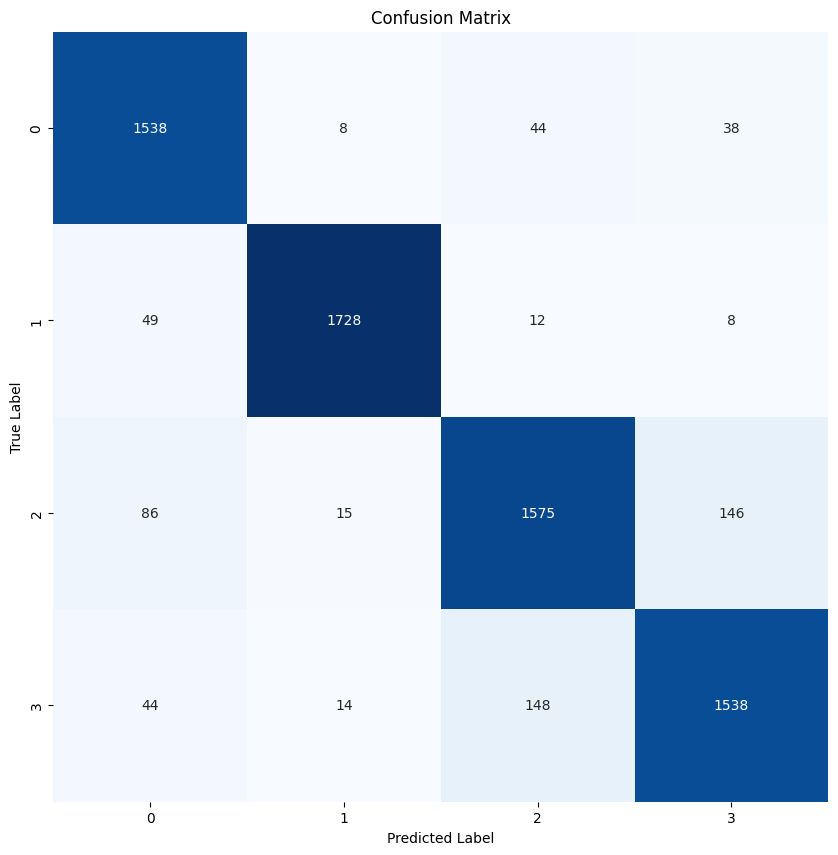

In [44]:
model = torch.load("models/model100.pt")
model.to(device)
matrix = get_confusion_matrix(model, test_loader)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt="g", cmap="Blues", cbar=False)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

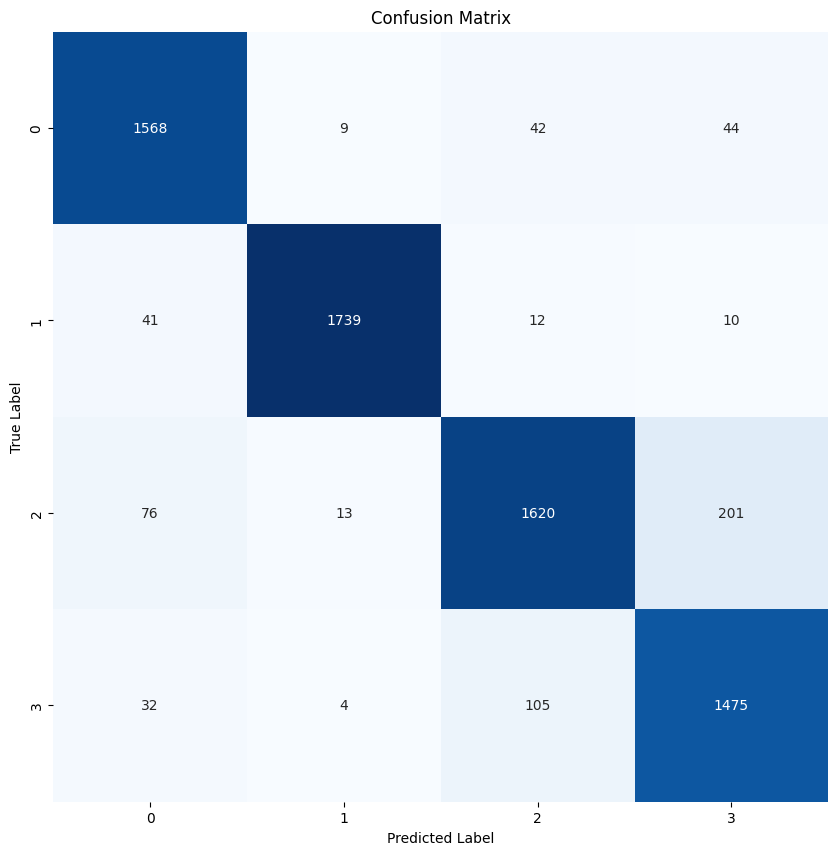

In [45]:
model = torch.load("models/model200.pt")
model.to(device)
matrix = get_confusion_matrix(model, test_loader)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt="g", cmap="Blues", cbar=False)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

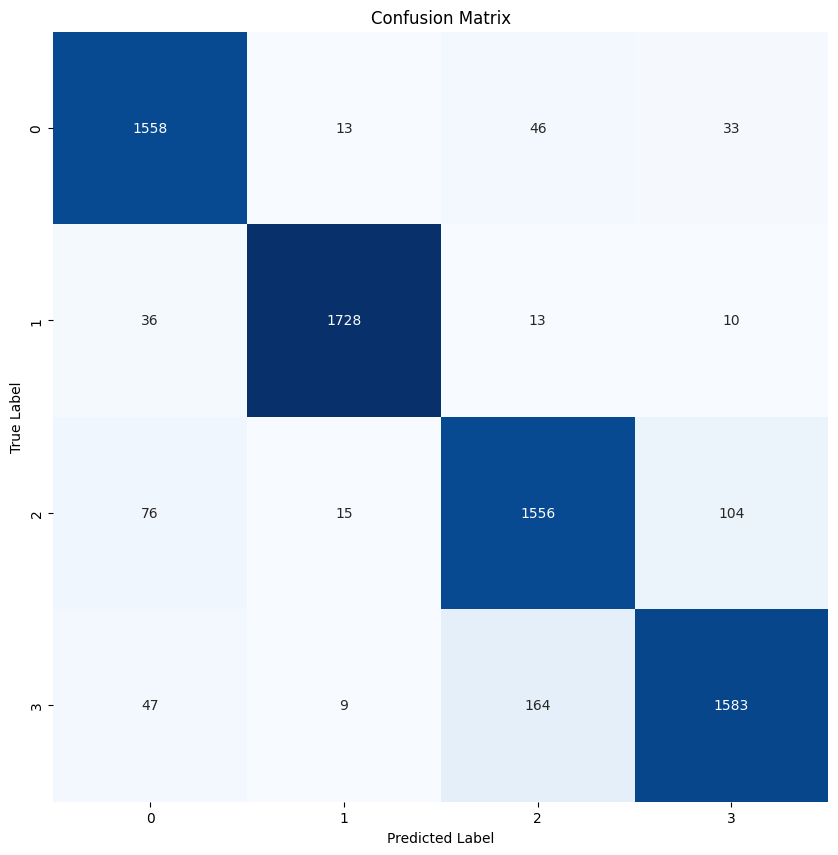

In [46]:
model = torch.load("models/model300.pt")
model.to(device)
matrix = get_confusion_matrix(model, test_loader)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt="g", cmap="Blues", cbar=False)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()